In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
%matplotlib inline

In [2]:
import csv

In [3]:
df = pd.read_csv('HW2housing.csv', delimiter=',')
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


### Data preparation

In [4]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
# Fill NAs with 0
df = df.fillna(0)

In [6]:
df['median_house_value'] = np.log1p(df['median_house_value'])

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [9]:
y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

In [10]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [13]:
dv = DictVectorizer(sparse=False)

### Q1 Which feature is used for splitting the data?

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [28]:
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [31]:
print(export_text(dtr, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



### Q2 What's the RMSE of this model on validation?

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [40]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [45]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = rf.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False).round(2)

0.25

### Q3 After which value of n_estimators does RMSE stop improving?

In [51]:
rmse_scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    rmse_scores.append((n, rmse))

In [52]:
columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(rmse_scores, columns=columns)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


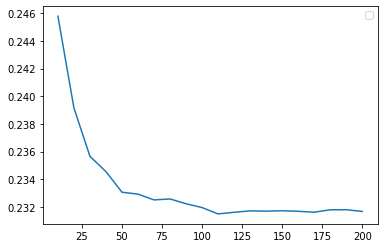

In [69]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
#plt.ylim(0.23, 0.234)
plt.legend()

In [70]:
df_scores[df_scores.rmse == df_scores.rmse.min()]

,n_estimators,rmse
10,110,0.231484


### Q4 What's the best max_depth

In [81]:
rmse_scores4 = []
for i in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=i,
                                   random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_scores4.append((i, n, rmse))

In [82]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(rmse_scores4, columns=columns)

In [84]:
import seaborn as sns

In [86]:
df_scores_pivot = df_scores.pivot(index='n_estimators',
                                  columns=['max_depth'],
                                  values=['rmse'])

<AxesSubplot: xlabel='None-max_depth', ylabel='n_estimators'>

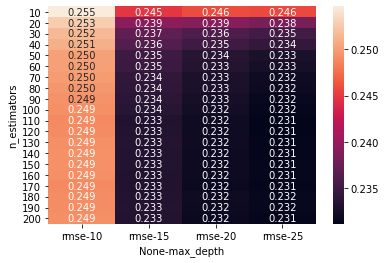

In [89]:
df_scores_pivot.round(3)
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [110]:
rmse = []
for i in [10, 15, 20, 25]:
    rmse_avg = df_scores[df_scores.max_depth == i].rmse.mean()
    rmse.append((i, rmse_avg))

In [111]:
columns = ['max_depth', 'avg_rmse']
df_rmse = pd.DataFrame(rmse, columns=columns)
df_rmse[df_rmse.avg_rmse == df_rmse.avg_rmse.min()]

,max_depth,avg_rmse
3,25,0.233022


### Q5 What's the most important feature?

In [126]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [147]:
df_importances = pd.DataFrame()
df_importances['feature_names'] = dv.get_feature_names_out()
df_importances['feature_importance'] = rf.feature_importances_
df_importances.sort_values(by='feature_importance', ascending=False).head(5)

,feature_names,feature_importance
4,median_income,0.363224
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101333
3,longitude,0.096341
1,housing_median_age,0.033197


#### Q6 Which eta leads to the best RMSE score on the validation dataset?

In [148]:
import xgboost as xgb

In [159]:
features = dv.get_feature_names_out()

In [160]:
features[5] = str(features[5].replace('<', 'lessthen'))

In [161]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [162]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [164]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [168]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model_eta03 = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  verbose_eval=5,
                  num_boost_round=200)

In [171]:
df_score_e03 = parse_xgb_output(output)

In [175]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model_eta01 = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  verbose_eval=5,
                  num_boost_round=200)

In [177]:
df_score_e01 = parse_xgb_output(output)

In [178]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model_eta001 = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  verbose_eval=5,
                  num_boost_round=200)

In [179]:
df_score_e001 = parse_xgb_output(output)

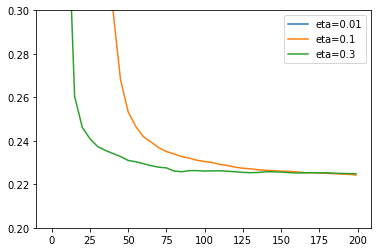

In [188]:
plt.plot(df_score_e001.num_iter, df_score_e001.val_auc, label='eta=0.01')
plt.plot(df_score_e01.num_iter, df_score_e01.val_auc, label='eta=0.1')
plt.plot(df_score_e03.num_iter, df_score_e03.val_auc, label='eta=0.3')
plt.ylim(0.2, 0.3)
plt.legend()

In [194]:
print(f' eta=0.3, avg rmse = {round(df_score_e03.val_auc.mean(), 3)}'),
print(f' eta=0.1, avg rmse = {round(df_score_e01.val_auc.mean(),3)}'),
print(f' eta=0.01, avg rmse = {round(df_score_e001.val_auc.mean(),3)}')

 eta=0.3, avg rmse = 0.454
 eta=0.1, avg rmse = 0.81
 eta=0.01, avg rmse = 5.007
